<a href="https://colab.research.google.com/github/Corry-Grodek/DataScience/blob/main/CorrGrodU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import libraries
!pip install bambi
!pip install git+https://github.com/pydata/xarray.git
!pip install preliz

import bambi as bmb
import arviz as az
import preliz as pz
import numpy as np
import seaborn as sns
import pandas as pd
import pymc as pm
from matplotlib import pyplot as plt

#import date tool
import dateutil.parser

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-d8pcofot
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-d8pcofot
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# **Trains**

I took a long time finding a data set for this project, most of the data sets I found had simple relationships that were not interesting enough to look into. The data set I found was on Data.gov had the percent that the New York Metro was on time every month since 2019. I wanted to see what the trend for this looked like over time.

 https://data.ny.gov/Transportation/MTA-Metro-North-On-Time-Performance-Beginning-2020/83hw-i6xw/about_data

First I had to convert the date format to an integer so the model (and later GP) would run. I decided to do months since the first date, as it was pretty simple. I figured this out with the help of a few websites and the dateutil add on.

https://dateutil.readthedocs.io/en/stable/examples.html

In [ ]:
#import data from GovData
trains = pd.read_csv('https://data.ny.gov/api/views/83hw-i6xw/rows.csv?accessType=DOWNLOAD').dropna()

#Rename columns
trains = trains.set_axis(['Month', 'Line', 'OTP', 'AMP', 'PMP', 'OTPOP'], axis=1)

#convert date to datetime format
trains['Month'] = pd.to_datetime(trains['Month'])
#Set orgin months date (first month on the chart)
m1 = pd.to_datetime('2020-01-01')
#Months from original month
trains['Months'] = (trains['Month'].dt.year - m1.year) * 12 + (trains['Month'].dt.month - m1.month)

trains

,Month,Line,OTP,AMP,PMP,OTPOP,Months
0,2020-01-01,Hudson,0.976,94.60%,98.00%,0.977,0
1,2020-01-01,Harlem,0.978,97.20%,98.00%,0.968,0
2,2020-01-01,New Haven,0.970,96.00%,98.30%,0.964,0
4,2020-01-01,Pascack Valley,0.964,95.20%,95.90%,0.955,0
5,2020-01-01,Port Jervis,0.913,92.10%,89.70%,0.924,0
...,...,...,...,...,...,...,...
422,2025-01-01,New Haven,0.976,96.60%,98.60%,0.977,60
423,2025-01-01,East of Hudson,0.979,97.00%,97.10%,0.983,60
424,2025-01-01,Pascack Valley,0.958,99.50%,96.60%,0.947,60
425,2025-01-01,Port Jervis,0.900,90.50%,93.70%,0.890,60


I wanted to see the data first, so I made a scatter plot. OTP is On Time Percentage. This felt like the most relavent data point, the peak and off peak would likely show the same trend. At the end of the project I will use the station data as well.

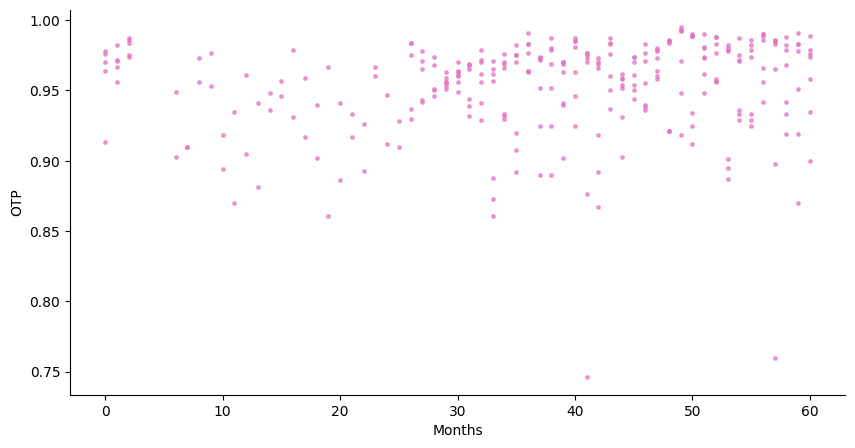

In [ ]:
#On time percentage compared to months since 2019
trains.plot(kind='scatter', x='Months', y='OTP', s=6, alpha=.7, c="C6", figsize=(10, 5), fontsize=10)
plt.gca().spines[['top', 'right',]].set_visible(False)

No super clear trend, but there is clearl a dip between 5-25 months. The percent was also was higher than I expected, I have never lived in a city with a rail system so I always assumed they were less reliable.

I then created 7 different models to see which one looked like it best captured the trend.

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


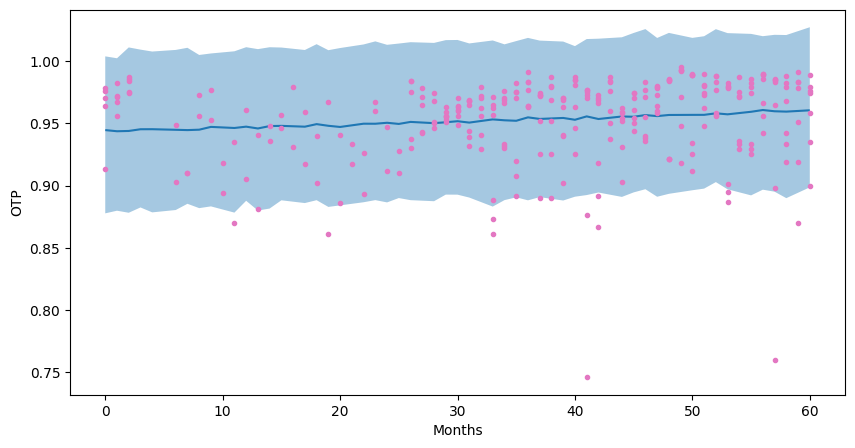

In [ ]:
model_trainsGLM = bmb.Model("OTP ~ Months", trains)
idata_trainsGLM = model_trainsGLM.fit()

bmb.interpret.plot_predictions(model_trainsGLM, idata_trainsGLM, "Months", pps=True,fig_kwargs={"figsize": (10, 5)} )
plt.plot(trains.Months, trains.OTP, "C6.", zorder=2, )

Straight line linear model, slight upwards trend over time.

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


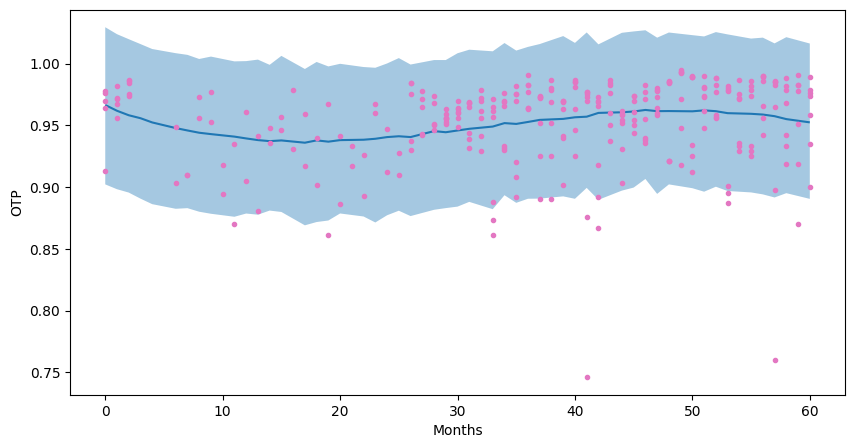

In [ ]:
model_trainsPOLY1 = bmb.Model("OTP ~ poly(Months, degree=3)", trains)
idata_trainsPOLY1 = model_trainsPOLY1.fit()

bmb.interpret.plot_predictions(model_trainsPOLY1, idata_trainsPOLY1, "Months", pps=True, fig_kwargs={"figsize": (10, 5)})
plt.plot(trains.Months, trains.OTP, "C6.", zorder=2)

More curved 3 degree polynomial mode, captures the decline in OTP between 5-25 months, and has an additional decline in the last 5-ish months.

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


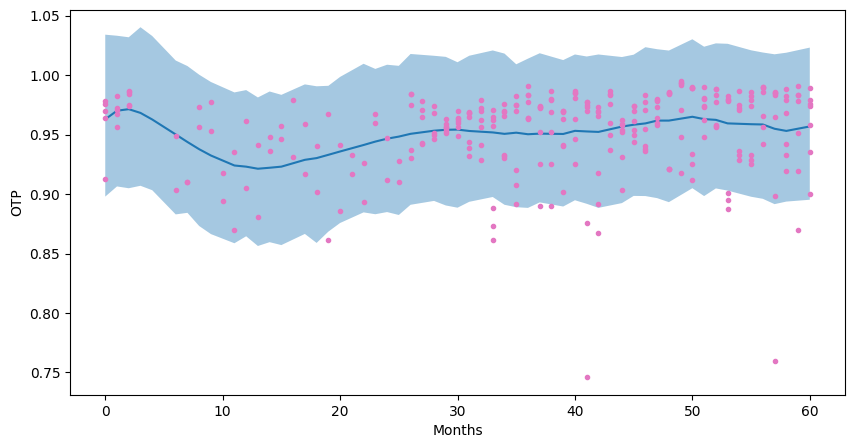

In [ ]:
model_trainsPOLY2 = bmb.Model("OTP ~ poly(Months, degree=7)", trains)
idata_trainsPOLY2 = model_trainsPOLY2.fit()

bmb.interpret.plot_predictions(model_trainsPOLY2, idata_trainsPOLY2, "Months", pps=True, fig_kwargs={"figsize": (10, 5)})
plt.plot(trains.Months, trains.OTP, "C6.", zorder=2)

The 7 degree polynomial model looks pretty similar to the 3 degree, but with some different behavior at the ends.

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


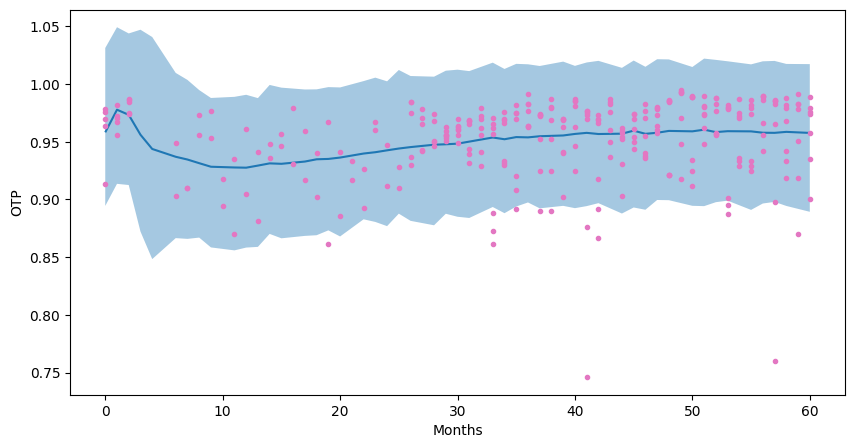

In [ ]:
num_knots = 6
knots = np.linspace(0, 23, num_knots+2)[1:-1]
model_trainsSPLINE = bmb.Model("OTP ~ bs(Months, degree=3, knots=knots)", trains)
idata_trainsSPLINE = model_trainsSPLINE.fit()

bmb.interpret.plot_predictions(model_trainsSPLINE, idata_trainsSPLINE, "Months", pps= True, fig_kwargs={"figsize": (10, 5)})
plt.plot(trains.Months, trains.OTP, "C6.", zorder=2)

The B-spline model looks the most accurate to the data, it has the dip between months 5-25 and the upwards trend from 30 onwards.

In [ ]:
#Hilbert Space GP from Unit 7 Notes

OTP = trains["OTP"].values
Months = trains["Months"].values[:,None]

def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(Months))
}

priors = {
    "hsgp(Months, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("OTP ~ 0 + hsgp(Months, m=10, c=1.5)", trains, priors=priors)
idata_hsb = model_hsb.fit()

Output()

ERROR:pymc.stats.convergence:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


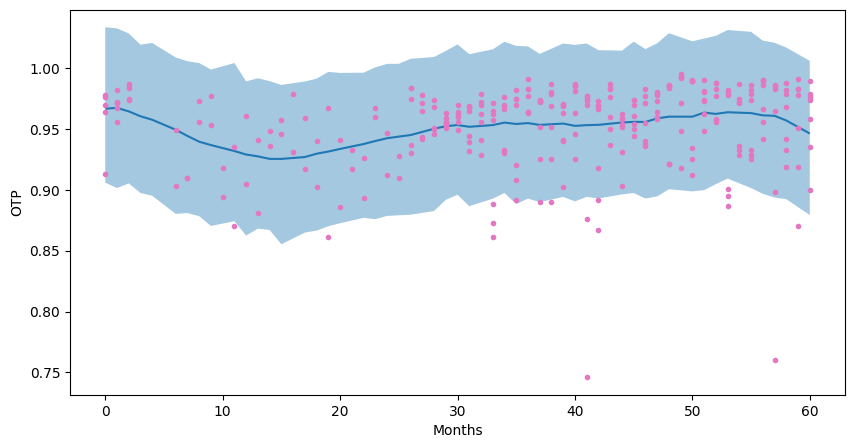

In [ ]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["Months"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 5)})
ax[0].plot(trains["Months"].values, trains["OTP"].values, "C6.")

The Hilber space GP model looks okay, it is pretty similar to the B spline, but with more downturn in the last 5 months.

I think this would be something difficult to predict into the future, as there are so many factors that go into the trains running on time, from funding and management to ridership and weather. Out of all the models the B spline LOOKED the most accurate. I do not think the polynomial model makes sense contextually, I don't think there is any formula that could describe this proccess.

I think the most notable trend in the data, the decline in OTP in months 5-25 is an anomally. There was something happening in 2020 and 2021, a pandemic! In New York metro ridership was down 90% during the pandemic, and trains stopped running at night to be disinfected. There are also much fewer data points, maybe the larger, more timely stations stopped reporting data?

(array([15., 12., 12., 12., 26., 42., 42., 42., 42., 49.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <BarContainer object of 10 artists>)

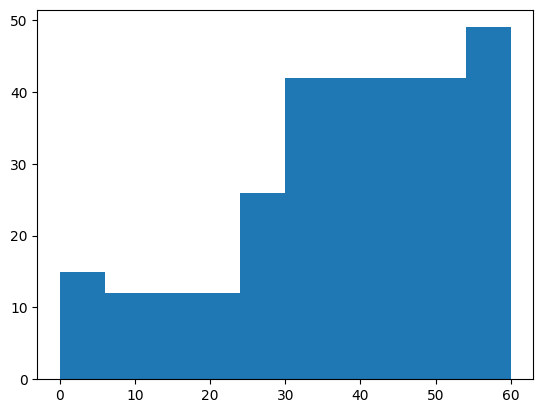

In [ ]:
#Amount of data points in each month
plt.hist(trains['Months'])

In [ ]:
#List all the branches
station_encode = pd.Categorical(trains['Line'])
station_encode

['Hudson', 'Harlem', 'New Haven', 'Pascack Valley', 'Port Jervis', ..., 'New Haven', 'East of Hudson', 'Pascack Valley', 'Port Jervis', 'West of Hudson']
Length: 294
Categories (7, object): ['East of Hudson', 'Harlem', 'Hudson', 'New Haven', 'Pascack Valley',
                         'Port Jervis', 'West of Hudson']

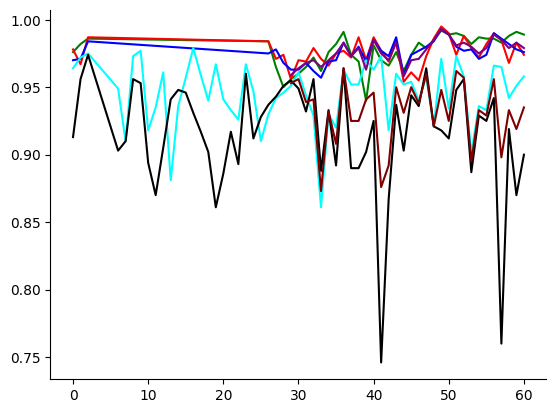

In [ ]:
_, ax = plt.subplots()

#Separate Lines
Hu = trainsS.query('Line == "Hudson"')
Ha = trainsS.query('Line == "Harlem"')
Nh = trainsS.query('Line == "New Haven"')
Pv = trainsS.query('Line == "Pascack Valley"')
Pj = trainsS.query('Line == "Port Jervis"')
Eh = trainsS.query('Line == "East of Hudson"')
Wh = trainsS.query('Line == "West of Hudson"')

#Plot each line
ax.plot(Hu.Months, Hu.OTP, "green", zorder=1)
ax.plot(Ha.Months, Ha.OTP, "red", zorder=2)
ax.plot(Nh.Months, Nh.OTP, "blue", zorder=3)
ax.plot(Pv.Months, Pv.OTP, "cyan", zorder=4)
ax.plot(Pj.Months, Pj.OTP, "black", zorder=5)
ax.plot(Eh.Months, Eh.OTP, "purple", zorder=6)
ax.plot(Wh.Months, Wh.OTP, "maroon", zorder=7)

#Look cooler
plt.gca().spines[['top', 'right',]].set_visible(False)

This pretty much confirmed my thinking, the most on-time lines (Hudson, New Haven, Harlem, East of Hudson) were not measured during the pandemic, while the late lines (Port of Jervis, Pascack Valley) continued to report their data.

I was not able to find why this would be, but I think the fact it aligns with the pandemic is not a coincidence. Because of this, I think the most accurate model was the GLM. There is not any clear relationships in the OTP since 2020  besides the pandemic dip, which I think makes sense for such a large institution with pretty consisent infrastructure.

If I had a larger data set I would be curious to see how OTP compare since the start of the NY Metro system, as I think there might be a stronger trends.